In [1]:
# Import dependencies

# Date range = 2018-07-13 to 2018-07-22
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from flask import jsonify

In [2]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [4]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [6]:
# Reflect Database into ORM class for measurements
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurements

In [7]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.stations

In [8]:
# Start a session to query the database
session = Session(engine)

In [9]:
# Query the date and prcp columns from the measurements table and filter for the past year
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>"2016-08-23").all()

In [39]:
# Load the results into a pandas dataframe. Set the index to the `date`
precip_df = pd.DataFrame(precip_data)
precip_df.set_index('date', inplace=True)
precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


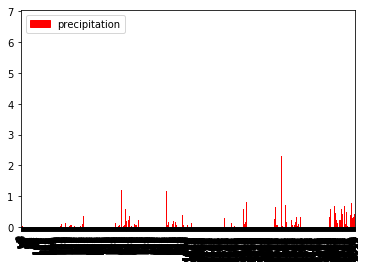

In [37]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
# Couldn't get this graph to work
precip_df.plot.bar(color='red')
red_patch = mpatches.Patch(color='red', label='precipitation')
plt.legend(handles=[red_patch])
plt.show()

In [33]:
precip_df['prcp'].max()

6.7

In [14]:
# Query the total number of stations
station_count = session.query(Station.station).count()
station_count

9

In [15]:
# Query measurement counts by station in decending order.  USC00519281 is the most active station.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [16]:
# Query the station and tobs columns from the measurements table and filter for the past year and filter by most active station
# Store the data in a dataframe
tobs_data = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date>"2016-08-23")\
.filter(Measurement.station=="USC00519281").all()
tobs_df = pd.DataFrame(tobs_data)
tobs_df.head()

,station,tobs
0,USC00519281,77
1,USC00519281,80
2,USC00519281,80
3,USC00519281,75
4,USC00519281,73


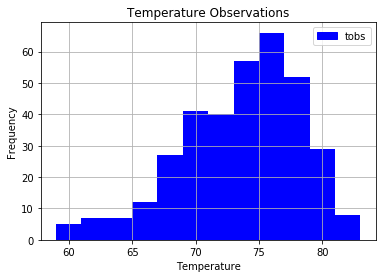

In [17]:
# Plot the data on a histogram with bins of 12
hist = tobs_df.hist(bins=12, color="blue")
plt.ylabel("Frequency")
plt.title("Temperature Observations")
plt.xlabel("Temperature")
blue_patch = mpatches.Patch(color='blue', label='tobs')
plt.legend(handles=[blue_patch])

In [18]:
# Define a function that will get min, max, and average temperatures for a given date range.
def calc_temps(Measurement):
    start_date = input("What is your start date (yyyy-mm-dd)? (Date range: 2010-01-01 to 2017-08-23) ")
    end_date = input("What is your end date (yyyy-mm-dd)? (Date range: 2010-01-01 to 2017-08-23) ")
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date<end_date).filter(Measurement.date>start_date).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date<end_date).filter(Measurement.date>start_date).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date<end_date).filter(Measurement.date>start_date).all()
    print(f'The minimum temperature for {start_date} to {end_date} is {min_temp[0][0]} degrees farenheight')
    print(f'The maximum temperature for {start_date} to {end_date} is {max_temp[0][0]} degrees farenheight')
    print(f'The average temperature for {start_date} to {end_date} is {int(avg_temp[0][0])} degrees farenheight')
    yerr = (max_temp[0][0]-min_temp[0][0])/2
    plt.figure(figsize=(2,5))
    plt.bar(1, avg_temp[0][0], width=1.3, color='orange', yerr=yerr)
    plt.ylim(0, 100)
    plt.xlim(0, 2, 1)
    plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    plt.grid(axis='y')
    plt.title('Trip Avg. Temp')
    plt.ylabel('Temperature (F)')

What is your start date (yyyy-mm-dd)? (Date range: 2010-01-01 to 2017-08-23) 2016-01-01
What is your end date (yyyy-mm-dd)? (Date range: 2010-01-01 to 2017-08-23) 2016-01-10
The minimum temperature for 2016-01-01 to 2016-01-10 is 62 degrees farenheight
The maximum temperature for 2016-01-01 to 2016-01-10 is 78 degrees farenheight
The average temperature for 2016-01-01 to 2016-01-10 is 70 degrees farenheight


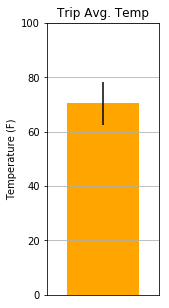

In [19]:
# Call the function above and run the data
calc_temps(Measurement)